# Lectura y Análisis

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error

# Missing values
from scipy.interpolate import CubicSpline
from scipy.interpolate import PchipInterpolator

## Carga de datos

### Lectura de ficheros

Se leen los distintos fichero con la información meteorlógica.

Se establece una cota temporal a los datos de todos los ficheros.

In [25]:
dataframes = {}

def load(file, directory, start_date=None, end_date=None):
    file_path = directory + file
    file_key = file.replace(".csv", "")  # Remove .csv extension for index
    print(f"Processing {file}...")
    
    try:
        df = pd.read_csv(file_path, parse_dates=['ts'], index_col='ts')
        df = df.sort_index()
        df_hourly = df.resample('h').mean()  # Resample by hour
        
        # Apply date filtering if start_date and end_date are provided
        if start_date and end_date:
            df_hourly = df_hourly.loc[start_date:end_date]
        
        dataframes[file_key] = df_hourly
    except Exception as e:
        print(f"Error processing {file}: {e}")

In [26]:
# Read the CSV files
directory = "data/"
arona_openmetoe_arpege = "openmeteo_arona_arpege.csv"
arona_openmetoe_icon = "openmeteo_arona_icon.csv"

arona_grafcan = "grafcan_arona.csv"

#########
# Dates #
#########
start_date = "2023-03-01"
end_date = "2025-02-28"

data_files = [arona_openmetoe_arpege,
              arona_openmetoe_icon,
              arona_grafcan]
for file in data_files:
    load(file, directory, start_date, end_date)


Processing openmeteo_arona_arpege.csv...
Processing openmeteo_arona_icon.csv...
Processing grafcan_arona.csv...


## Visualización

In [27]:
def plot_datasets(datasets, column):
    """
    Plot a specific column from each dataset (given as a list of filenames)
    for all common years.
    
    Parameters:
        datasets (list): List of dataset filenames (e.g., ['file1.csv', 'file2.csv', ...]).
        column (str): The column name to plot from each dataset.
    """
    # Remove .csv extension if present and check if each dataset is loaded
    dataset_names = [name.replace(".csv", "") for name in datasets]
    for name in dataset_names:
        if name not in dataframes:
            print(f"Dataset '{name}' is not loaded.")
            return

    # Retrieve the dataframes
    dfs = [dataframes[name] for name in dataset_names]

    # Align all dataframes on their timestamps by concatenating on axis=1 (inner join ensures common timestamps)
    # Using keys creates a hierarchical column index: top level is dataset name, lower level is the original columns.
    combined = pd.concat(dfs, axis=1, join='inner', keys=dataset_names)
    
    # Ensure the indicated column exists in every dataset
    for name in dataset_names:
        if column not in combined[name].columns:
            print(f"Column '{column}' not found in dataset '{name}'.")
            return

    # Get all common years from the combined index
    common_years = combined.index.year.unique()
    
    # Plot the indicated column for each dataset by year
    for year in common_years:
        df_year = combined[combined.index.year == year]
        plt.figure(figsize=(10, 6))
        for name in dataset_names:
            plt.plot(df_year.index, df_year[name][column],
                     label=f"{name}", linestyle='-', alpha=0.7)
        plt.title(f'Comparison Plot - Column "{column}" - Year {year}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()


### OpenMeteo

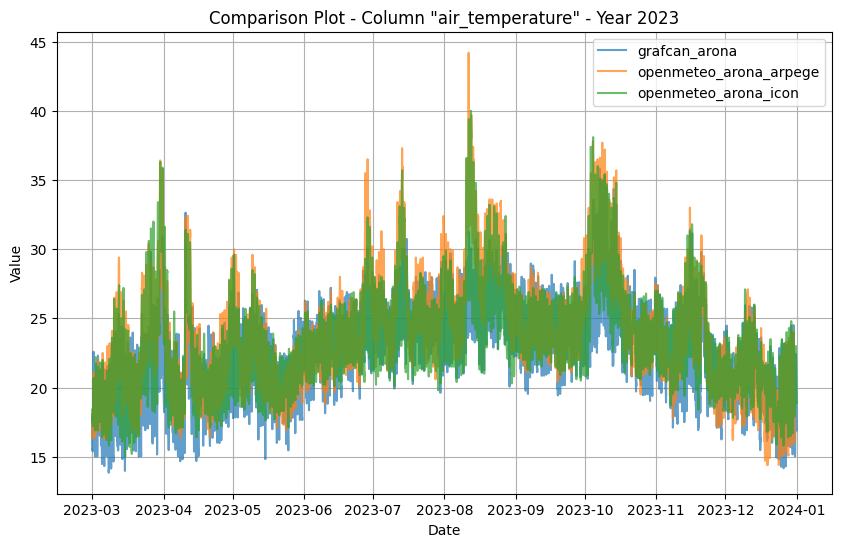

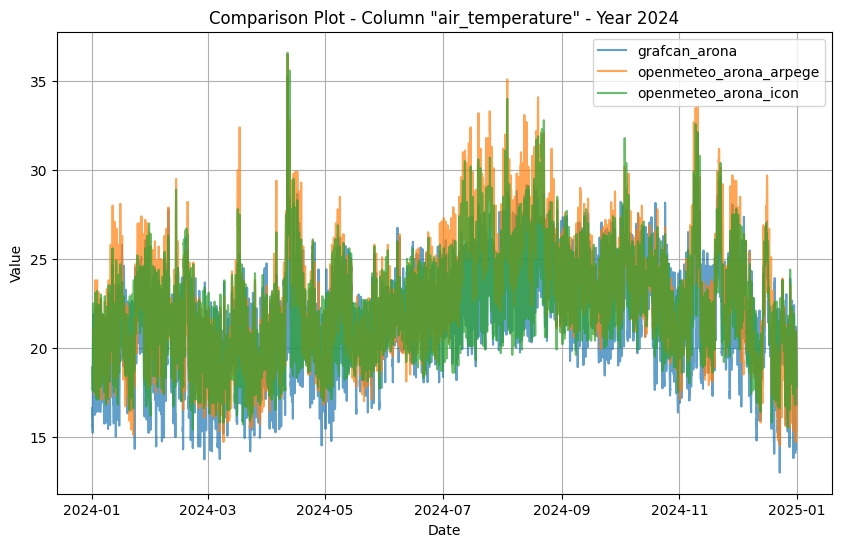

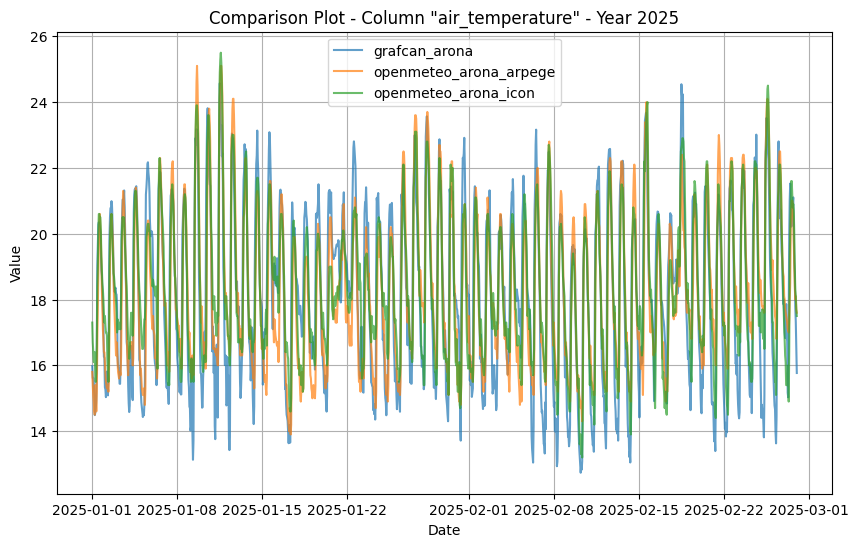

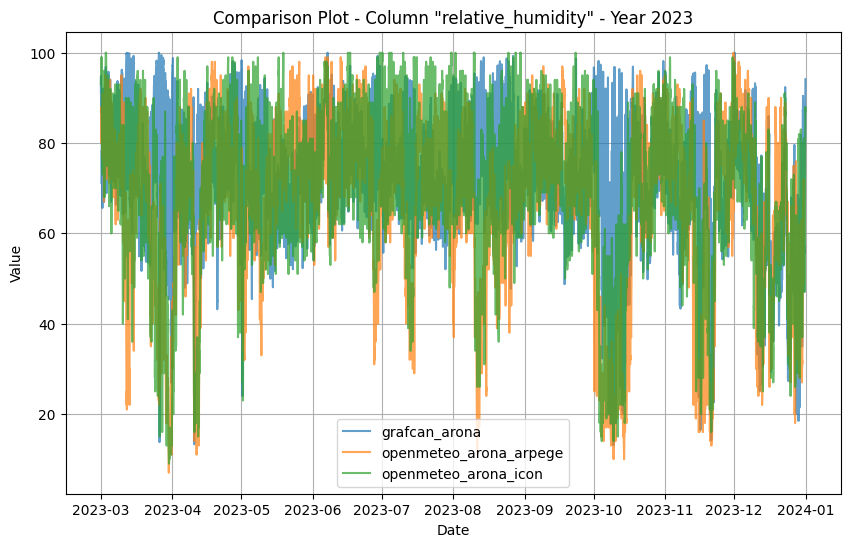

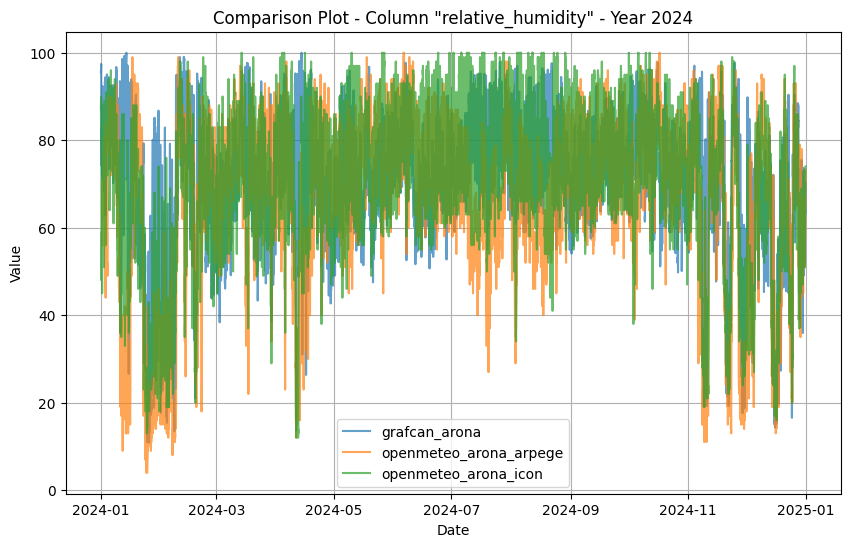

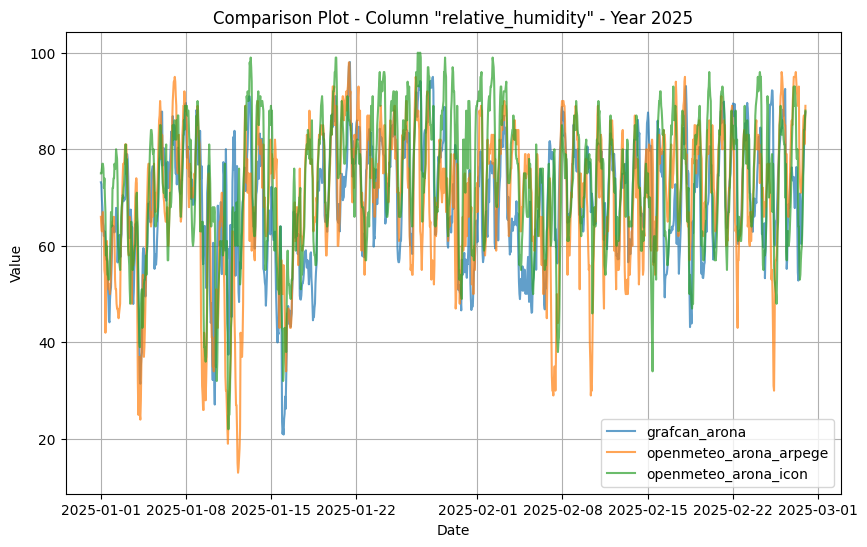

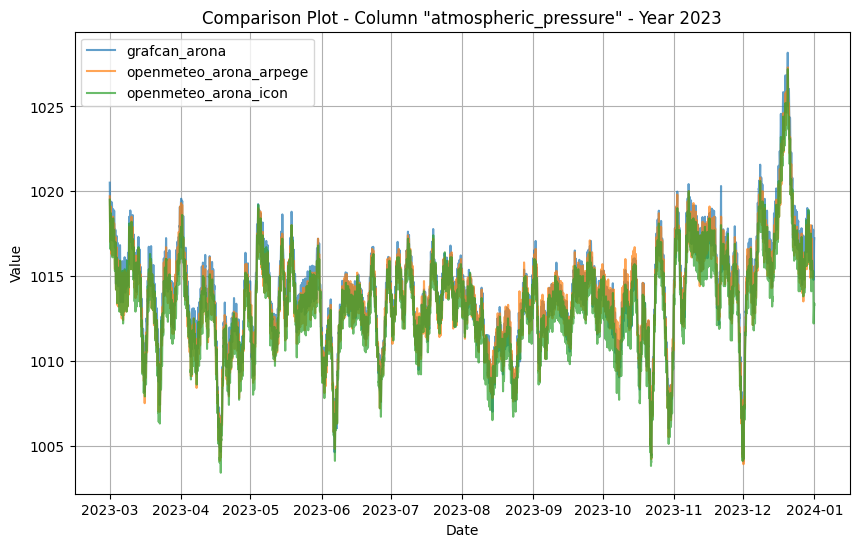

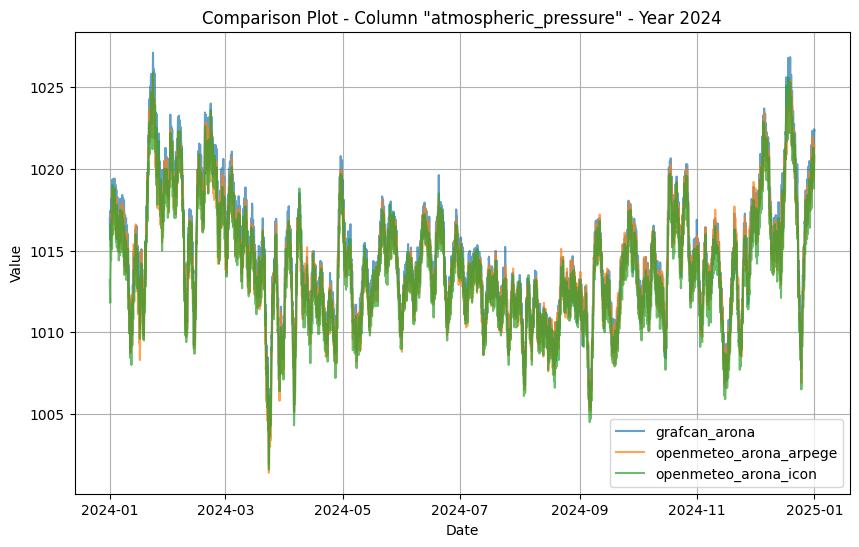

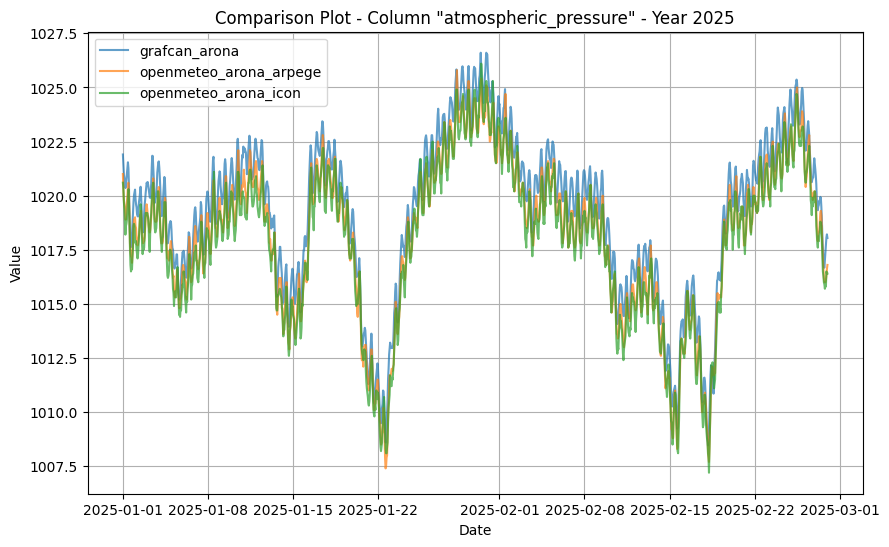

In [28]:
plot_datasets([arona_grafcan, arona_openmetoe_arpege, arona_openmetoe_icon], "air_temperature")
plot_datasets([arona_grafcan, arona_openmetoe_arpege, arona_openmetoe_icon], "relative_humidity")
plot_datasets([arona_grafcan, arona_openmetoe_arpege, arona_openmetoe_icon], "atmospheric_pressure")

## Horas faltantes

In [29]:
    
for file_key, df_hourly in dataframes.items():
    # Check for missing hours in the time series
    # Detect missing hours after resampling
    missing_hours = df_hourly[df_hourly.isna().any(axis=1)].index

    # Print missing hours if any
    if len(missing_hours) > 0:
        print(f"Missing hours in {file_key} after resampling:")
        print(missing_hours.tolist())
        print(len(missing_hours))
    else:
        print(f"No missing hours in {file_key} after resampling.")

Missing hours in openmeteo_arona_arpege after resampling:
[Timestamp('2023-12-31 07:00:00+0000', tz='UTC'), Timestamp('2023-12-31 08:00:00+0000', tz='UTC'), Timestamp('2023-12-31 09:00:00+0000', tz='UTC'), Timestamp('2023-12-31 10:00:00+0000', tz='UTC'), Timestamp('2023-12-31 11:00:00+0000', tz='UTC'), Timestamp('2023-12-31 12:00:00+0000', tz='UTC'), Timestamp('2023-12-31 13:00:00+0000', tz='UTC'), Timestamp('2023-12-31 14:00:00+0000', tz='UTC'), Timestamp('2023-12-31 15:00:00+0000', tz='UTC'), Timestamp('2023-12-31 16:00:00+0000', tz='UTC'), Timestamp('2023-12-31 17:00:00+0000', tz='UTC'), Timestamp('2023-12-31 18:00:00+0000', tz='UTC'), Timestamp('2023-12-31 19:00:00+0000', tz='UTC'), Timestamp('2023-12-31 20:00:00+0000', tz='UTC'), Timestamp('2023-12-31 21:00:00+0000', tz='UTC'), Timestamp('2023-12-31 22:00:00+0000', tz='UTC'), Timestamp('2023-12-31 23:00:00+0000', tz='UTC'), Timestamp('2024-01-01 00:00:00+0000', tz='UTC'), Timestamp('2024-01-01 01:00:00+0000', tz='UTC'), Timestamp(

### Manejo Horas faltantes

In [30]:
# Cubic Spline Interpolation Algorithm

def pchip_interpolation(df):
 # Convert datetime index to a numeric format (Unix timestamp in seconds)
    numeric_index = df.index.astype(np.int64) // 10**9

    # Iterate over each feature column and apply cubic spline interpolation
    for col in df.columns:
        valid_mask = ~df[col].isna()
        # Check if there are enough valid points for interpolation
        if valid_mask.sum() >= 2:

            pchip = PchipInterpolator(numeric_index[valid_mask], df.loc[valid_mask, col])
            interpolated_values = pchip(numeric_index)

            #cs = CubicSpline(numeric_index[valid_mask], df.loc[valid_mask, col], bc_type='natural')
            #interpolated_values = cs(numeric_index)
            df[col] = df[col].fillna(pd.Series(interpolated_values, index=df.index))
        else:
            print(f"Not enough data points to interpolate column '{col}'.")
            
    return df

In [31]:
for file_key, df_hourly in dataframes.items():
    # Perform cubic spline interpolation on the dataframe
    pchip_interpolation(df_hourly)

## Comparativa datasets predicciones

In [32]:
def datasets_similarity(file1, file2):
    # Remove .csv extension if present
    file1 = file1.replace(".csv", "")
    file2 = file2.replace(".csv", "")
    
    # Ensure datasets are loaded
    if file1 not in dataframes or file2 not in dataframes:
        print("One or both datasets are not loaded.")
        return
    
    # Retrieve dataframes and align by timestamp
    df1 = dataframes[file1]
    df2 = dataframes[file2]
    df1, df2 = df1.align(df2, join='inner')
    
    similarity_results = {}
    for column in df1.columns:
        if column in df2.columns:
            try:
                pearson_corr, _ = pearsonr(df1[column], df2[column])
                spearman_corr, _ = spearmanr(df1[column], df2[column])
                kendall_corr, _ = kendalltau(df1[column], df2[column])
                mse = mean_squared_error(df1[column], df2[column])
                euclid_dist = euclidean(df1[column], df2[column])
                
                similarity_results[column] = {
                    "Pearson": pearson_corr,
                    "Spearman": spearman_corr,
                    "Kendall": kendall_corr,
                    "MSE": mse,
                    "Euclidean Distance": euclid_dist
                }
            except Exception as e:
                print(f"Error calculating similarity for {column}: {e}")
    
    print(f"Similarity Metrics for {file1} vs {file2}")
    for col, metrics in similarity_results.items():
        print(f"  {col}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")


In [33]:
datasets_similarity(arona_openmetoe_icon, arona_grafcan)

Similarity Metrics for openmeteo_arona_icon vs grafcan_arona
  air_temperature:
    Pearson: 0.8870
    Spearman: 0.9115
    Kendall: 0.7488
    MSE: 2.8639
    Euclidean Distance: 224.0040
  atmospheric_pressure:
    Pearson: 0.9890
    Spearman: 0.9859
    Kendall: 0.9047
    MSE: 1.1093
    Euclidean Distance: 139.4162
  relative_humidity:
    Pearson: 0.6280
    Spearman: 0.6024
    Kendall: 0.4422
    MSE: 208.8094
    Euclidean Distance: 1912.7336


In [34]:
datasets_similarity(arona_openmetoe_arpege, arona_grafcan)

Similarity Metrics for openmeteo_arona_arpege vs grafcan_arona
  air_temperature:
    Pearson: 0.8407
    Spearman: 0.8511
    Kendall: 0.6641
    MSE: 5.6374
    Euclidean Distance: 314.2820
  atmospheric_pressure:
    Pearson: 0.9891
    Spearman: 0.9865
    Kendall: 0.9067
    MSE: 0.5794
    Euclidean Distance: 100.7528
  relative_humidity:
    Pearson: 0.3835
    Spearman: 0.2742
    Kendall: 0.1970
    MSE: 406.3329
    Euclidean Distance: 2668.2127


## Detección de outliers



In [35]:
def detect_outliers_iqr(df, threshold=1.5, return_indices=False):
    """
    Detects and plots outliers in each numerical column of a Pandas DataFrame using the Interquartile Range (IQR) method.
    Optionally returns indices of the detected outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        threshold (float): The multiplier for the IQR to determine outlier boundaries.
        return_indices (bool): If True, also return a dictionary of outlier indices for each column.
        
    Returns:
        outliers_dict (dict): A dictionary containing outlier values for each numerical column.
        outlier_indices_dict (dict, optional): A dictionary containing outlier row indices for each numerical column.
    """
    outliers_dict = {}
    outlier_indices_dict = {}
    
    for column in df.select_dtypes(include=[np.number]).columns:
        # Calculate IQR-based bounds
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Identify outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        outliers_dict[column] = outliers.tolist()
        outlier_indices_dict[column] = outliers.index.tolist()
        
        # Create subplots for boxplot and histogram
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
        
        # Boxplot on the left with outliers highlighted
        ax1.boxplot(df[column], vert=False)
        ax1.scatter(outliers, [1] * len(outliers), color='red', label='Outliers')
        ax1.set_title(f'Boxplot of {column}')  # Fixed typo here
        ax1.set_xlabel(column)
        ax1.legend()
        
        # Histogram on the right with bounds indicated
        ax2.hist(df[column], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
        ax2.axvline(lower_bound, color='red', linestyle='dashed', linewidth=1, label='Lower bound')
        ax2.axvline(upper_bound, color='red', linestyle='dashed', linewidth=1, label='Upper bound')
        ax2.set_title(f'Histogram of {column}')
        ax2.set_xlabel(column)
        ax2.set_ylabel('Frequency')
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
    
    if return_indices:
        return outliers_dict, outlier_indices_dict
    return outliers_dict


Processing openmeteo_arona_arpege:


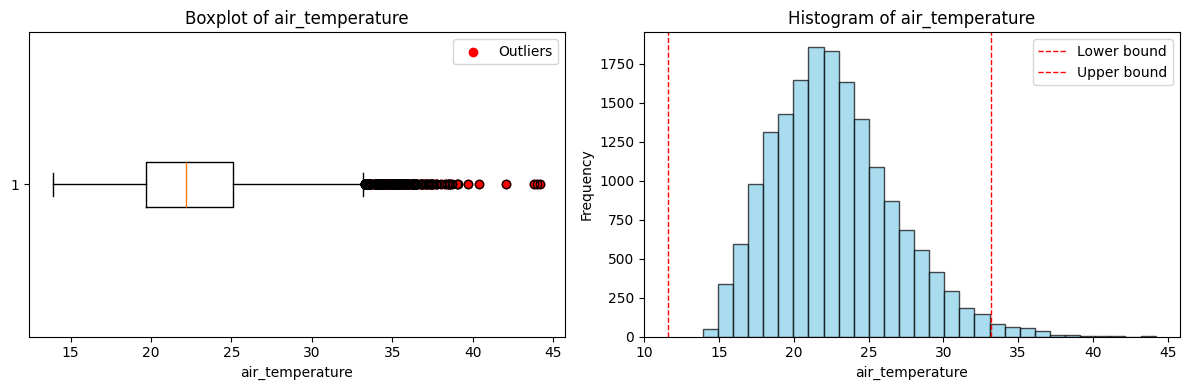

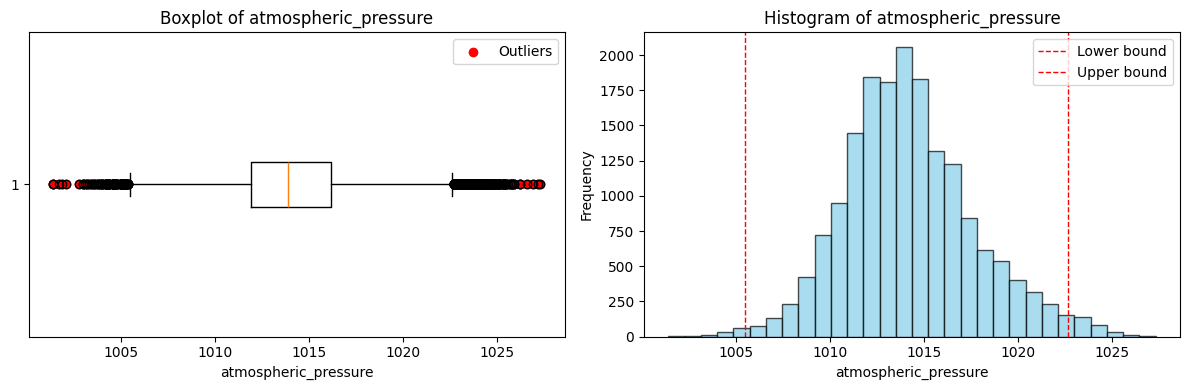

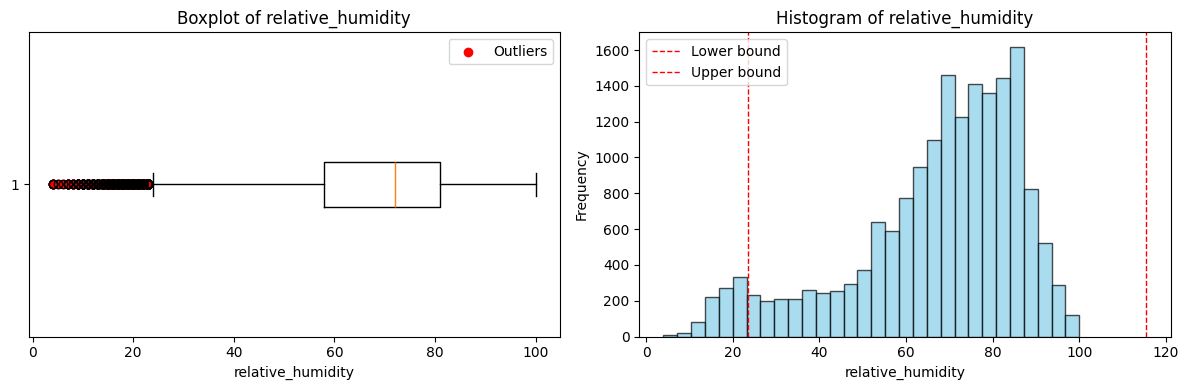

  air_temperature outlier row indices: [Timestamp('2023-03-30 10:00:00+0000', tz='UTC'), Timestamp('2023-03-30 11:00:00+0000', tz='UTC'), Timestamp('2023-03-30 12:00:00+0000', tz='UTC'), Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:00+0000', tz='UTC'), Timestamp('2023-03-30 15:00:00+0000', tz='UTC'), Timestamp('2023-03-30 16:00:00+0000', tz='UTC'), Timestamp('2023-03-30 17:00:00+0000', tz='UTC'), Timestamp('2023-03-30 18:00:00+0000', tz='UTC'), Timestamp('2023-03-30 19:00:00+0000', tz='UTC'), Timestamp('2023-03-31 13:00:00+0000', tz='UTC'), Timestamp('2023-03-31 14:00:00+0000', tz='UTC'), Timestamp('2023-03-31 15:00:00+0000', tz='UTC'), Timestamp('2023-03-31 16:00:00+0000', tz='UTC'), Timestamp('2023-06-27 14:00:00+0000', tz='UTC'), Timestamp('2023-06-27 15:00:00+0000', tz='UTC'), Timestamp('2023-06-27 16:00:00+0000', tz='UTC'), Timestamp('2023-06-27 17:00:00+0000', tz='UTC'), Timestamp('2023-06-27 18:00:00+0000', tz='UTC'), Timestamp('2023-06-27 19:00:0

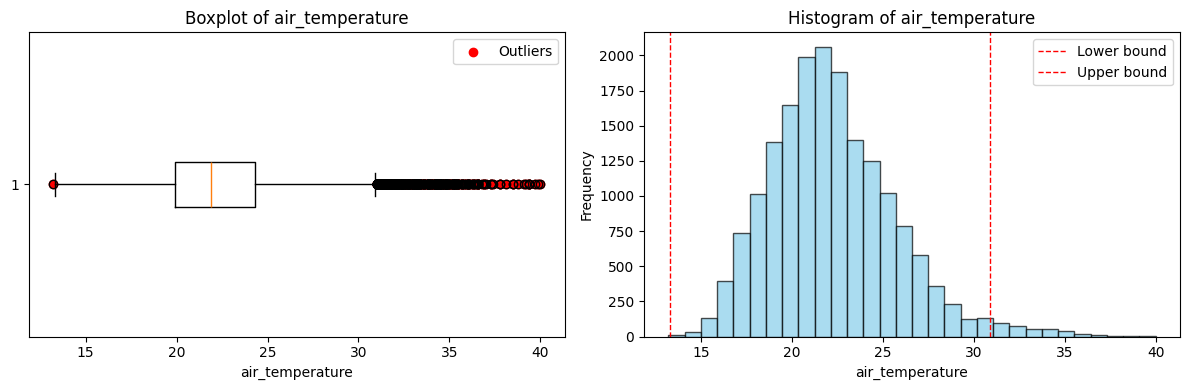

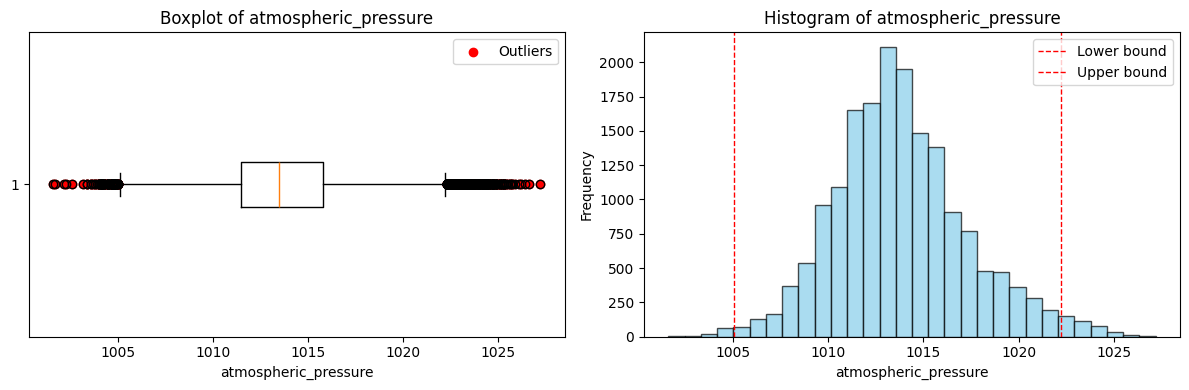

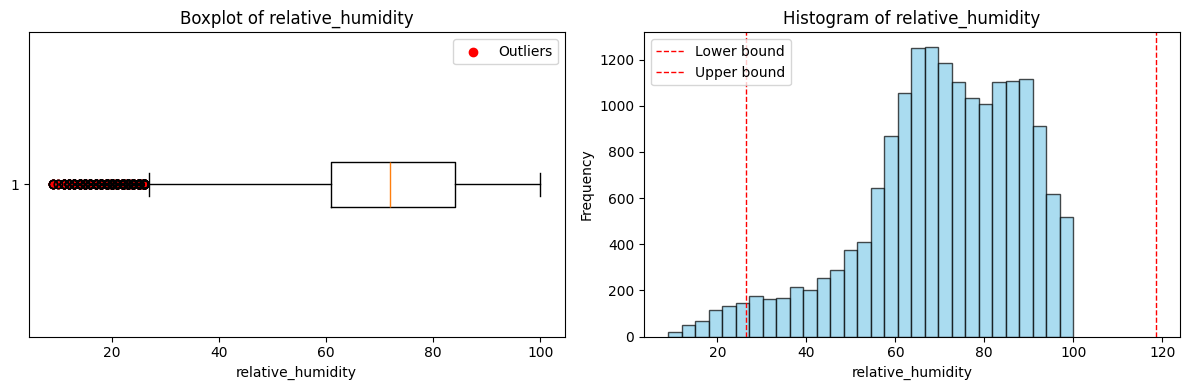

  air_temperature outlier row indices: [Timestamp('2023-03-26 11:00:00+0000', tz='UTC'), Timestamp('2023-03-26 12:00:00+0000', tz='UTC'), Timestamp('2023-03-26 13:00:00+0000', tz='UTC'), Timestamp('2023-03-26 14:00:00+0000', tz='UTC'), Timestamp('2023-03-27 14:00:00+0000', tz='UTC'), Timestamp('2023-03-27 15:00:00+0000', tz='UTC'), Timestamp('2023-03-27 16:00:00+0000', tz='UTC'), Timestamp('2023-03-29 12:00:00+0000', tz='UTC'), Timestamp('2023-03-29 13:00:00+0000', tz='UTC'), Timestamp('2023-03-29 14:00:00+0000', tz='UTC'), Timestamp('2023-03-29 15:00:00+0000', tz='UTC'), Timestamp('2023-03-29 16:00:00+0000', tz='UTC'), Timestamp('2023-03-29 17:00:00+0000', tz='UTC'), Timestamp('2023-03-29 18:00:00+0000', tz='UTC'), Timestamp('2023-03-30 09:00:00+0000', tz='UTC'), Timestamp('2023-03-30 10:00:00+0000', tz='UTC'), Timestamp('2023-03-30 11:00:00+0000', tz='UTC'), Timestamp('2023-03-30 12:00:00+0000', tz='UTC'), Timestamp('2023-03-30 13:00:00+0000', tz='UTC'), Timestamp('2023-03-30 14:00:0

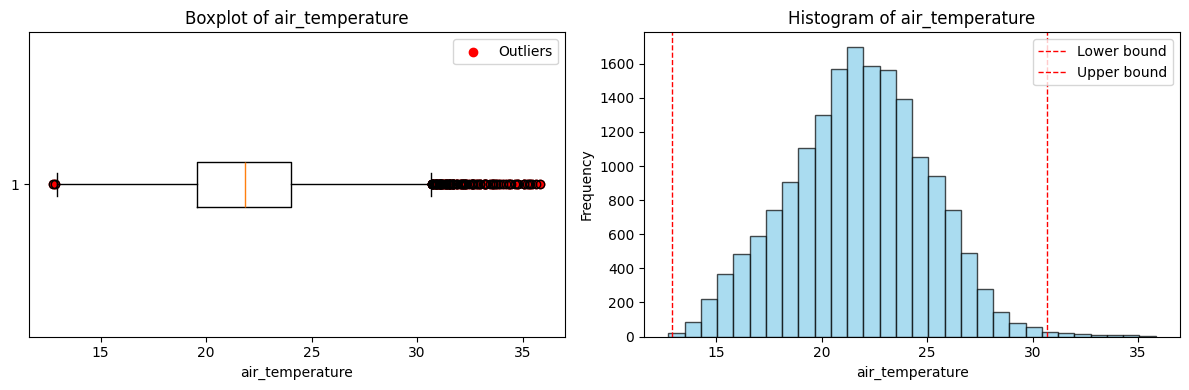

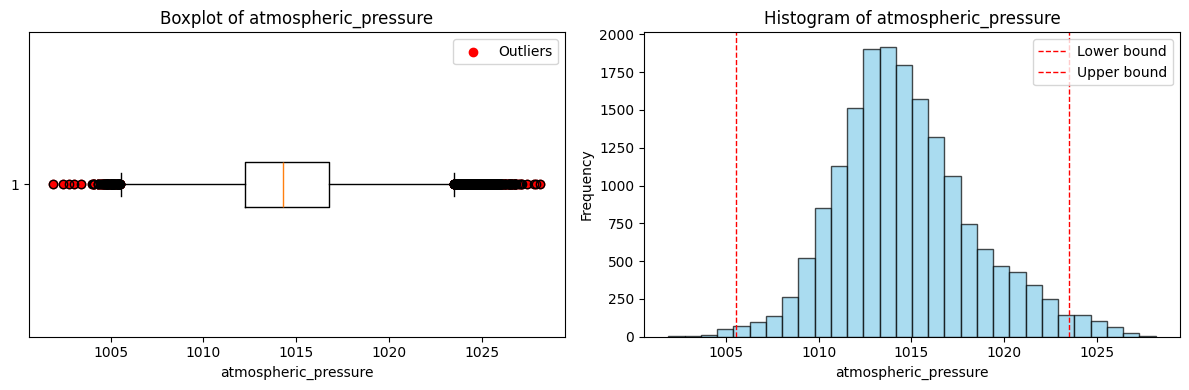

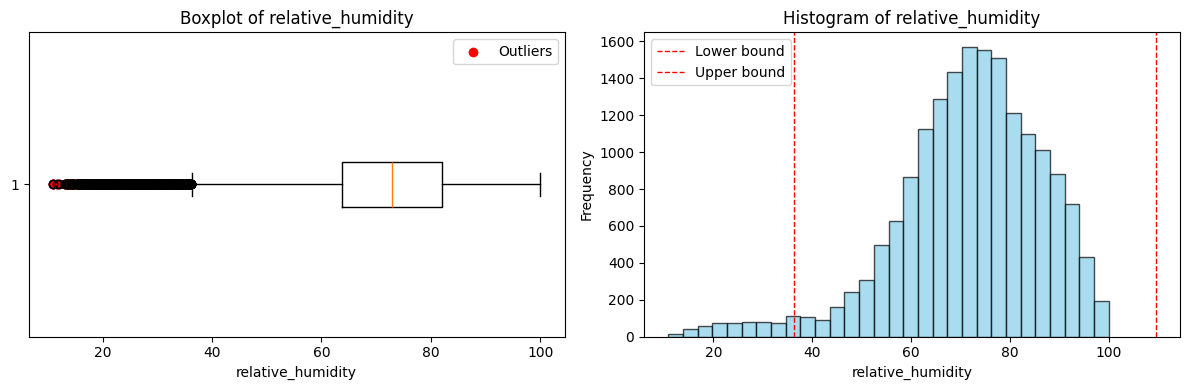

  air_temperature outlier row indices: [Timestamp('2023-03-31 12:00:00+0000', tz='UTC'), Timestamp('2023-04-10 11:00:00+0000', tz='UTC'), Timestamp('2023-04-10 12:00:00+0000', tz='UTC'), Timestamp('2023-04-10 13:00:00+0000', tz='UTC'), Timestamp('2023-04-10 14:00:00+0000', tz='UTC'), Timestamp('2023-04-10 15:00:00+0000', tz='UTC'), Timestamp('2023-07-15 14:00:00+0000', tz='UTC'), Timestamp('2023-07-15 15:00:00+0000', tz='UTC'), Timestamp('2023-08-11 13:00:00+0000', tz='UTC'), Timestamp('2023-08-11 14:00:00+0000', tz='UTC'), Timestamp('2023-08-14 13:00:00+0000', tz='UTC'), Timestamp('2023-08-27 15:00:00+0000', tz='UTC'), Timestamp('2023-10-04 11:00:00+0000', tz='UTC'), Timestamp('2023-10-04 12:00:00+0000', tz='UTC'), Timestamp('2023-10-04 13:00:00+0000', tz='UTC'), Timestamp('2023-10-04 14:00:00+0000', tz='UTC'), Timestamp('2023-10-04 15:00:00+0000', tz='UTC'), Timestamp('2023-10-04 16:00:00+0000', tz='UTC'), Timestamp('2023-10-04 17:00:00+0000', tz='UTC'), Timestamp('2023-10-05 15:00:0

In [36]:
threshold = 1.5

for file_key, df_hourly in dataframes.items():
    print(f"Processing {file_key}:")
    
    # Use the modified function to get both outlier values and their indices
    outliers, outlier_indices = detect_outliers_iqr(df_hourly, threshold, return_indices=True)
    
    # Print outliers for each column
    for column, indices in outlier_indices.items():
        print(f"  {column} outlier row indices: {indices}")
    
    # Combine all outlier indices from every column
    all_outlier_indices = set()
    for indices in outlier_indices.values():
        all_outlier_indices.update(indices)
    
    # Remove rows with any detected outlier
    #df_clean = df_hourly.drop(list(all_outlier_indices))
    #dataframes[file_key] = df_clean
    
    print(f"Removed {len(all_outlier_indices)} rows with outliers from {file_key}.\n")


## Adición datos temporales

In [37]:
# Extract hour and minute to get a more continuous representation of time within a day
df = dataframes["grafcan_arona"].copy()
df.index.name = "time"
df.reset_index(inplace=True)

df['time'] = pd.to_datetime(df['time'])
hours = df['time'].dt.hour
minutes  = df['time'].dt.minute
hour_fraction = hours + minutes / 60.0

# Convert the hour fraction into sine and cosine features to capture cyclical patterns (period = 24 hours)
df['sin_day'] = np.sin(2 * np.pi * hour_fraction / 24)
df['cos_day'] = np.cos(2 * np.pi * hour_fraction / 24)

# Extract day of the week (0 = Monday, 6 = Sunday)
day_of_week = df['time'].dt.weekday

# Compute the continuous week fraction (e.g., Monday at noon = 0.5, Sunday at 23:59 = 6.999)
week_fraction = day_of_week + hour_fraction / 24.0  # Continuous representation of the week

# Encode the continuous week representation using sine and cosine (for weekly cycle, period = 7 days)
df['sin_week'] = np.sin(2 * np.pi * week_fraction / 7)
df['cos_week'] = np.cos(2 * np.pi * week_fraction / 7)

# For annual features: extract the day of the year (1-366)
day_of_year = df['time'].dt.dayofyear

# Create a continuous representation of the year:
# Subtracting 1 from day_of_year makes it start at 0, then add the fractional day.
year_fraction = (day_of_year - 1) + hour_fraction / 24.0

# Convert the continuous year representation into sine and cosine features (assuming period = 365 days)
df['sin_year'] = np.sin(2 * np.pi * year_fraction / 365)
df['cos_year'] = np.cos(2 * np.pi * year_fraction / 365)

# Remove original time variable
#df.drop(columns="time", inplace=True)

                              time  air_temperature  atmospheric_pressure  \
time                  1.000000e+00        -0.166057              0.231012   
air_temperature      -1.660568e-01         1.000000             -0.326707   
atmospheric_pressure  2.310120e-01        -0.326707              1.000000   
relative_humidity    -1.146823e-01        -0.287476             -0.312924   
sin_day              -1.061880e-03        -0.355245              0.028062   
cos_day               1.542596e-17        -0.483861              0.003340   
sin_week              4.086278e-03         0.006952              0.012865   
cos_week              1.966047e-03        -0.013765             -0.008122   
sin_year             -2.082231e-01        -0.467293              0.160809   
cos_year              3.324178e-01        -0.384702              0.505574   

                      relative_humidity       sin_day       cos_day  sin_week  \
time                          -0.114682 -1.061880e-03  1.542596e-17  0.

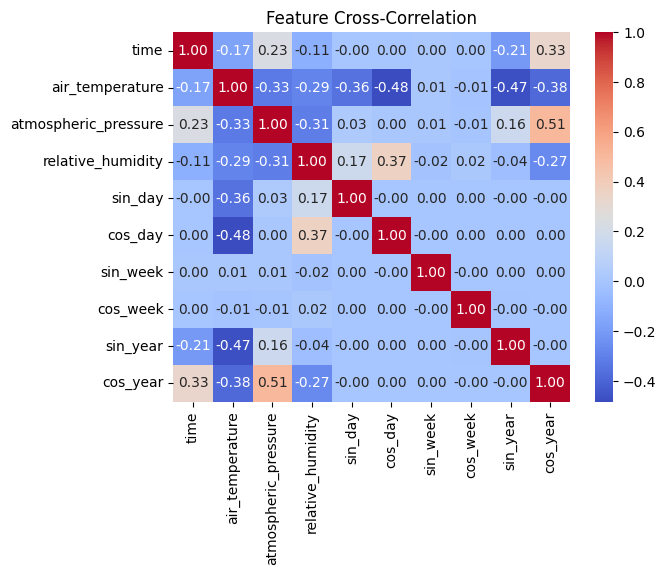

In [38]:
import seaborn as sns
# Compute correlation matrix
correlation_matrix = df.corr()

# Print correlation values
print(correlation_matrix)

# Heatmap for visualization
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Cross-Correlation")
plt.show()


In [39]:
df.drop(columns=["sin_week", "cos_week"], inplace=True)

## Creación Dataset Entrenamiento

In [40]:
import keras
import tensorflow as tf


# Test/Train split #
####################
target_day = '2025-01-01'

indices = df[df['time'].dt.date == pd.to_datetime(target_day).date()].index
first_2025_day_index = indices[0]
print(df.iloc[first_2025_day_index])

###################################################
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return [(data - data_mean) / data_std, data_mean, data_std]
#################################################

features = df.drop(columns=["time", "sin_day", "cos_day", "sin_year", "cos_year"])
normalized_features, mean, std = normalize(features.values, first_2025_day_index)
normalized_features = pd.DataFrame(normalized_features, columns=features.columns)
normalized_features["sin_day"] = df["sin_day"]
normalized_features["cos_day"] = df["cos_day"]
normalized_features["sin_year"] = df["sin_year"]
normalized_features["cos_year"] = df["cos_year"]
print("Normalized: ", normalized_features.head())

train_data = normalized_features.loc[0 : first_2025_day_index]
val_data = normalized_features.loc[first_2025_day_index:]

# Training data structure #
###########################
past = 30
HOURS_TO_FORECAST = 3
future = HOURS_TO_FORECAST

# Labels start after past data
label_start = past
label_end = label_start + first_2025_day_index

x_train = train_data
# y_train = normalized_features.iloc[label_start:label_end]
y_train = normalized_features.iloc[label_start:label_end].drop(columns=["sin_day", "cos_day", "sin_year", "cos_year"])
y_train_multi = np.array([y_train[i:i+future] for i in range(len(y_train) - future + 1)])

# Validation data structure #
#############################
x_val_end = len(val_data) - past - future
val_label_start = first_2025_day_index + past

x_val = val_data.iloc[:x_val_end]
# y_val = normalized_features.iloc[val_label_start:]
y_val = normalized_features.iloc[val_label_start:].drop(columns=["sin_day", "cos_day", "sin_year", "cos_year"])
y_val_multi = np.array([y_val[i:i+future] for i in range(len(y_val) - future + 1)])

# Parameters #
##############
learning_rate = 0.001
batch_size =128
epochs = 10
step = 1 

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val_multi,
    sequence_length=past,
    sampling_rate=step,
    batch_size=batch_size,
)

tf.data.Dataset.save(dataset_train, "dataset_train_arona")
tf.data.Dataset.save(dataset_val, "dataset_val_arona")


for batch_x, batch_y in dataset_train.take(1):  # Take the first batch
    print("First batch X:", batch_x.numpy())
    print("First batch Y:", batch_y.numpy())



2025-03-23 21:00:36.471867: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-23 21:00:36.614442: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-23 21:00:36.726873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742763636.825501 1011236 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742763636.863646 1011236 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 21:00:37.140199: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

time                    2025-01-01 00:00:00+00:00
air_temperature                         15.974892
atmospheric_pressure                  1021.903005
relative_humidity                       73.158684
sin_day                                       0.0
cos_day                                       1.0
sin_year                                      0.0
cos_year                                      1.0
Name: 16128, dtype: object
Normalized:     air_temperature  atmospheric_pressure  relative_humidity   sin_day  \
0        -1.279423              1.817089           1.274692  0.000000   
1        -1.689525              1.712162           1.524067  0.258819   
2        -1.912225              1.529103           1.310070  0.500000   
3        -1.988888              1.341704           0.981654  0.707107   
4        -2.012103              1.171347           0.982266  0.866025   

    cos_day  sin_year  cos_year  
0  1.000000  0.849817  0.527078  
1  0.965926  0.850195  0.526468  
2  0.866025  0.8505

W0000 00:00:1742763640.434648 1011236 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


First batch X: [[[-1.27942272e+00  1.81708902e+00  1.27469236e+00 ...  1.00000000e+00
    8.49817092e-01  5.27077709e-01]
  [-1.68952492e+00  1.71216192e+00  1.52406722e+00 ...  9.65925826e-01
    8.50194924e-01  5.26468034e-01]
  [-1.91222463e+00  1.52910273e+00  1.31006990e+00 ...  8.66025404e-01
    8.50572319e-01  5.25858090e-01]
  ...
  [-1.77582461e+00  1.11304207e+00  1.04673995e+00 ...  7.07106781e-01
    8.59864478e-01  5.10522360e-01]
  [-1.95090460e+00  9.61921762e-01  1.03817734e+00 ...  5.00000000e-01
    8.60230433e-01  5.09905483e-01]
  [-2.06565868e+00  9.26570553e-01  9.59106485e-01 ...  2.58819045e-01
    8.60595946e-01  5.09288345e-01]]

 [[-1.68952492e+00  1.71216192e+00  1.52406722e+00 ...  9.65925826e-01
    8.50194924e-01  5.26468034e-01]
  [-1.91222463e+00  1.52910273e+00  1.31006990e+00 ...  8.66025404e-01
    8.50572319e-01  5.25858090e-01]
  [-1.98888812e+00  1.34170437e+00  9.81654182e-01 ...  7.07106781e-01
    8.50949276e-01  5.25247874e-01]
  ...
  [-1.95

2025-03-23 21:00:42.596632: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-03-23 21:00:42.687142: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 7)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 28)             │         4,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │           261 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 3, 3)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,293 (16.77 KB)

 Trainable params: 4,293 (16.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
124/126 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4809
Epoch 1: val_loss improved from inf to 0.32670, saving model to model_checkpoint.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.4778 - val_loss: 0.3267 - learning_rate: 0.0050
Epoch 2/150
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1834
Epoch 2: val_loss improved from 0.32670 to 0.16263, saving model to model_checkpoint.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1831 - val_loss: 0.1626 - learning_rate: 0.0050
Epoch 3/150
121/126 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1303
Epoch 3: val_loss improved from 0.16263 to 0.11011, saving model to model_checkpoint.weights.h5
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1302 - val_loss: 0.1101 - learning_rate: 0.0050
Epoch 4/150
122/126 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1142
Epoch 4: val_loss did not improve from 0.11011
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1143 - val_loss: 0.1146 - learning_rate: 0.

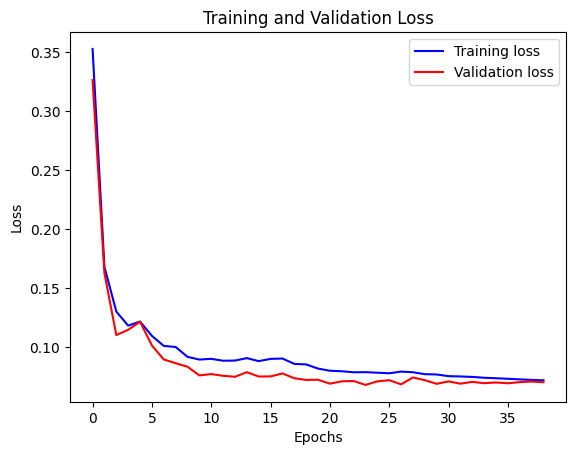

In [41]:
############
# Training #
epochs = 150
learning_rate = 0.005

dataset_train = tf.data.Dataset.load("dataset_train")
dataset_val = tf.data.Dataset.load("dataset_val")

for batch in dataset_train.take(1):
    inputs, targets = batch
    
#print("here?")

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(28)(inputs)

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(64))(inputs)

#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=True))(inputs)
#lstm_out = keras.layers.Bidirectional(keras.layers.LSTM(16))(lstm_out)

# lstm_out = keras.layers.LSTM(24, return_sequences=True)(inputs)
# lstm_out = keras.layers.LSTM(32, return_sequences=True)(lstm_out)
# lstm_out = keras.layers.LSTM(24)(lstm_out)


# Ensure the Dense layer outputs the correct shape
#lstm_out = keras.layers.Dense(16, activation='tanh')(lstm_out)
output_units = targets.shape[1] * targets.shape[2]  # Flatten output shape
outputs = keras.layers.Dense(output_units)(lstm_out)

# Reshape to match the target shape
outputs = keras.layers.Reshape((targets.shape[1], targets.shape[2]))(outputs)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

path_checkpoint = "model_checkpoint.weights.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

# Added reduce on plateau
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.7,         # reduce LR by a factor of 0.5
    patience=4,         # wait for 5 epochs before reducing
    verbose=1,
    min_lr=1e-7
)


history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    #callbacks=[es_callback, modelckpt_callback],
    callbacks=[es_callback, modelckpt_callback, reduce_lr_callback],
    #callbacks=[modelckpt_callback, reduce_lr_callback],
    
)

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

Index(['air_temperature', 'atmospheric_pressure', 'relative_humidity'], dtype='object')
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  


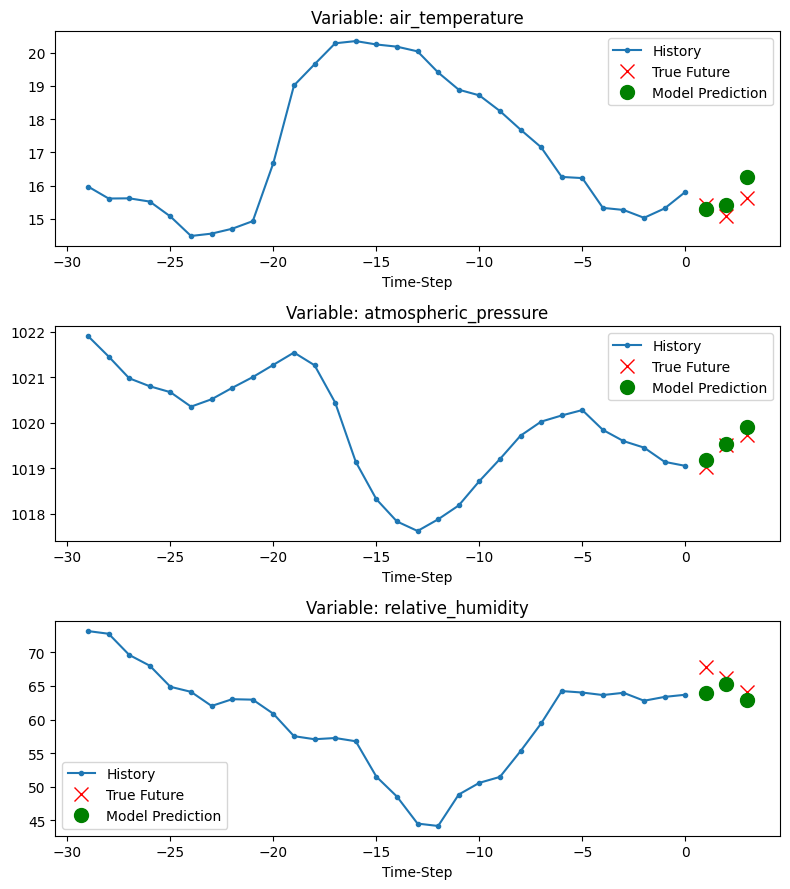

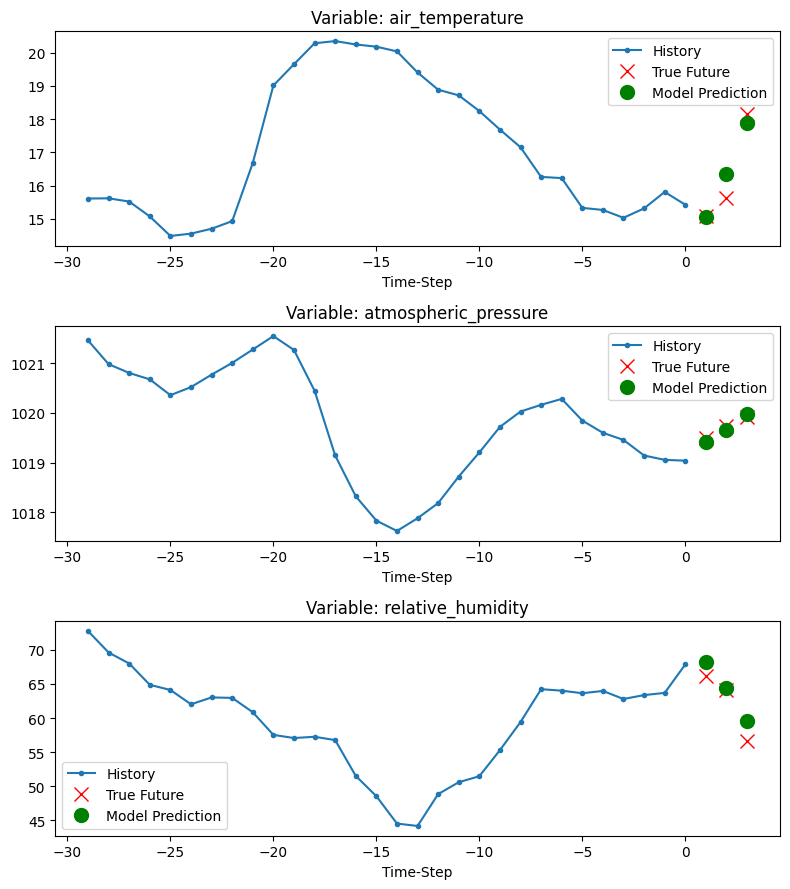

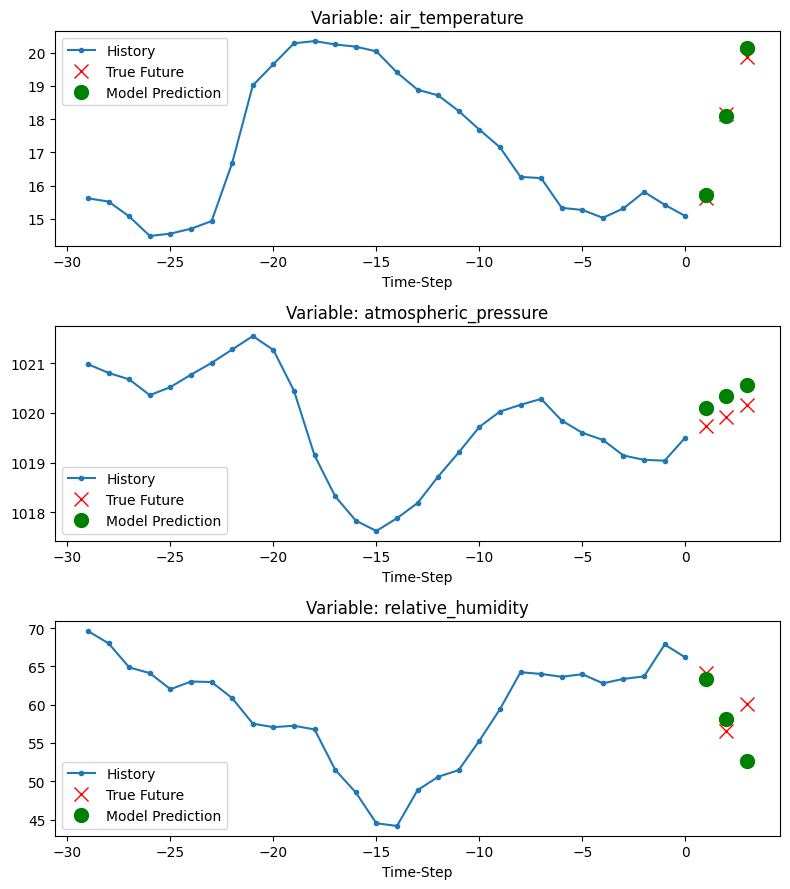

In [42]:
def show_plots_for_variables(plot_data, delta, feature_names, mean, std):
    """
    Plots separate graphs for each variable, showing the 3 forecast points in true scale.
    
    Parameters:
    - plot_data: List containing [history, true future, model prediction].
    - delta: Time step offset for forecasts.
    - feature_names: List of feature names for labeling each subplot.
    - mean: Mean values for each feature (for denormalization).
    - std: Standard deviation values for each feature (for denormalization).
    """
    labels = ["History", "True Future", "Model Prediction"]
    markers = [".-", "rx", "go"]
    num_variables = plot_data[0].shape[1]  # Number of features

    fig, axes = plt.subplots(num_variables, 1, figsize=(8, num_variables * 3))

    if num_variables == 1:
        axes = [axes]  # Ensure axes is iterable for a single variable

    for i in range(num_variables):
        ax = axes[i]

        # Convert normalized values back to real scale
        history = plot_data[0][:, i] * std[i] + mean[i]
        true_future = plot_data[1][:, i] * std[i] + mean[i]
        prediction = plot_data[2][:, i] * std[i] + mean[i]

        time_steps = list(range(-len(history)+ 1, 1))
        ax.plot(time_steps, history, markers[0], label=labels[0])

        # Plot forecasts
        forecast_time = list(range(delta + 1, delta + len(true_future) + 1))
        ax.plot(forecast_time, true_future, markers[1], markersize=10, label=labels[1])
        ax.plot(forecast_time, prediction, markers[2], markersize=10, label=labels[2])

        ax.set_title(f"Variable: {feature_names[i]}")
        ax.set_xlabel("Time-Step")
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Extract feature names (assuming dataset has feature names available)
feature_names = features.columns[:3]  # Modify if real names exist
print(feature_names)

# Assuming `mean` and `std` are arrays with the same length as the number of features
for x, y in dataset_val.take(1):
    prediction = model.predict(x)
    show_plots_for_variables([x[0][:, :3].numpy(), y[0].numpy(), prediction[0]], 0, feature_names, mean, std)
    show_plots_for_variables([x[1][:, :3].numpy(), y[1].numpy(), prediction[1]], 0, feature_names, mean, std)
    show_plots_for_variables([x[2][:, :3].numpy(), y[2].numpy(), prediction[2]], 0, feature_names, mean, std)

## Escritura fichero 

In [43]:
for file_key, df_hourly in dataframes.items():
  print(file_key)
  print(df_hourly.describe())

openmeteo_arona_arpege
       air_temperature  atmospheric_pressure  relative_humidity
count     17544.000000          17544.000000       17544.000000
mean         22.676575           1014.183208          66.981589
std           4.047808              3.484086          19.677793
min          13.900000           1001.400000           4.000000
25%          19.700000           1011.900000          58.000000
50%          22.200000           1013.900000          72.000000
75%          25.100000           1016.200000          81.000000
max          44.200000           1027.300000         100.000000
openmeteo_arona_icon
       air_temperature  atmospheric_pressure  relative_humidity
count     17544.000000          17544.000000       17544.000000
mean         22.239626           1013.802462          70.308368
std           3.497935              3.505928          17.882686
min          13.200000           1001.600000           9.000000
25%          19.900000           1011.500000          61.000